© 2018 Suzy Beeler. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](lacI_titration_day2.ipynb).
___

# Objective 

In this tutorial, we will be embarking on a large endeavor to compare theory and experiment in the context of gene expression in *E. coli*. In lecture, we derived a mathematical prediction of how the expression of a reporter gene (YFP) should change in response to increasing copy number of the LacI repressor. Here, we will make plots of our predictions as well as go through all the data analysis needed to plot the data on top of our theory to see how they compare.

# Part 1: Using phase images to get segmentation masks

At the end of the day, we are interesting in determining the amount of YFP expression in *E. coli* with varying copy numbers of the repressor, LacI. Before we can assess the amount of fluorescence, we first need to find where the cell are in the images. To do this, it's important to use a channel that is independent of the reporter gene, so we will be using phase images to get our segmentation masks. 

## 1.1: Background subtraction

Let's first look at a sample image.

In [1]:
# import the usual 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for nice plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(style='ticks', rc=rc)

# show images in viridis by default
plt.rcParams['image.cmap'] = 'viridis'

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure

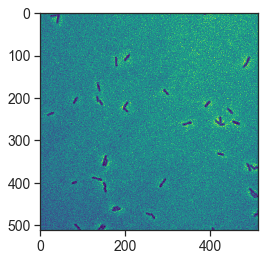

In [2]:
# Read an example phase contrast image
im = skimage.io.imread('data/lacI_titration/O2_R22_phase_pos_19.tif')

# Show the image
plt.imshow(im)

This image is noisy and unevenly illuminated, where the top right corner is brighter than the bottom left. This gradient of pixel intensity, is not biologically relevant, and is actually something we would like to remove. We can fix this by *background subtracting* the image. To get the "background" we need to blur the image, removing any fine-detail structures (like the bacteria). 

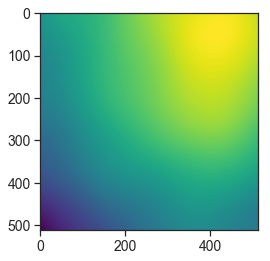

In [3]:
# normalize it
im_float = (im - np.min(im))/(np.max(im)-np.min(im))

# find the background
gauss_radius = 50
im_bg = skimage.filters.gaussian(im_float, sigma=gauss_radius)

# show the background
plt.imshow(im_bg)

Now that we have the background image, we can subtract it from the original image.

Text(0.5,1,'background-subtracted image')

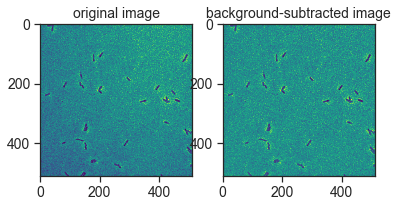

In [4]:
# perform a background subtraction
im_bs = im_float - im_bg

# show the background-subtracted image
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_float)
ax[0].set_title('original image')

ax[1].imshow(im_bs)
ax[1].set_title('background-subtracted image')

Nice! We can see that the background of our background-subtracted image is a lot more even now. 

## 1.2: Thresholding

Now that we have cleaned up the image a little bit, we can start to distinguishing bacteria from background. We will do these by *thresholding* the image, similar to how we did [on the first day](bacterial_growth.html). To figure out a good threshold, let's plot the histogram of pixel intensities. 

Text(0,0.5,'count')

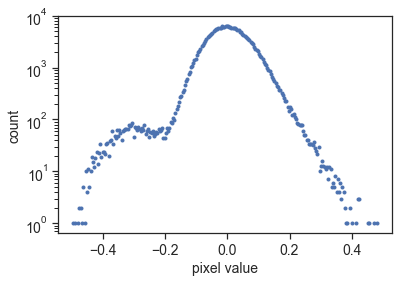

In [5]:
hist, pixel_vals = skimage.exposure.histogram(im_bs)

plt.plot(pixel_vals, hist, '.')
plt.yscale('log')
plt.xlabel('pixel value')
plt.ylabel('count')

By plotting with the $y$-axis logarithmically scaled, we can distinguish one hump of low pixel intensities (bacteria) from another hump of high pixel intensities (background). There is a sharp transition around $-0.2$ where we transition from bacteria to background, and we will use this as our threshold. 

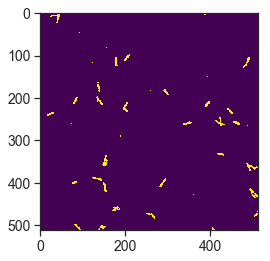

In [6]:
# Choose a threshold
threshold = -0.2

# Thresholded image
im_thresh = im_bs < threshold

# Show the thresholded image
plt.imshow(im_thresh)

## 1.3: Label and get sizes of the objects in the image

Our thresholding did okay, but we see we have a lot of single pixels and a lot of clumps that don't correspond to individual bacteria. To remove these features that don't correspond to the bacteria, we will first *label* the image using `skimage.measure.label()`. This function will look for contiguous islands of $1$ pixels in our labeled image and assign each island as an object. Let's label our image and plot the result.

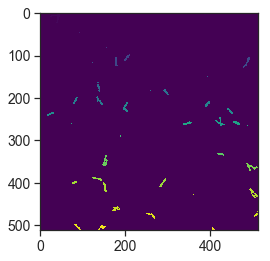

In [7]:
# label the objects in the binary image
im_label = skimage.measure.label(im_thresh)

# show the labeled image in a colored scale
plt.imshow(im_label)

We see that each object whether it's a bacterium, a clump, or a single pixel was assigned a different pixel intensity (i.e. a different color). This is the result of `skimage.measure.label()` assigning all the pixels in the first object with pixel intensity $1$, and all the pixels in the second object with pixel intensity $2$, and so on, until all the objects have been uniquely identified. This means we can find the total number of objects in the image by looking at the maximum value in the image.

In [8]:
print("Objects in image:", im_label.max())

Objects in image: 87


Now that we have a labeled image, we will call `skimage.measure.regionprops()` to compute properties of each unique object. `regionprops` computes many things for us (like centroid, eccentricity, diameter, etc.), but we will just be using area, which accessed by `object.area` for a given object from the labeled image. Let's plot the areas (converted to µm$^2$) of all the objects in our image.

Text(0,0.5,'count')

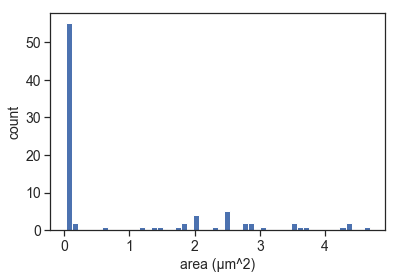

In [9]:
# length calibration 
pixel_size = 0.16 # µm

# list to store area values in um^2
areas = []

# obtain the areas of all labeled objects
objs = skimage.measure.regionprops(im_label)

# loop through the objects and update 
for obj in objs:
    areas.append(obj.area * pixel_size**2)
    
# Take a look at the distribution
_ = plt.hist(areas, bins = 50)
plt.xlabel('area (µm^2)')
plt.ylabel('count')

## 1.4: Remove non-bacteria objects from the image.

We see that there are a lot of very small objects in the image that certainly aren't bacteria. Additionally, things larger than 4 µm$^2$ are likely multiple bacteria. We would like to remove these objects, and we can do so by initially starting with a blank image (filled with all $0$s), and populating the image with only objects from our labeled image that are of a permissible size. 

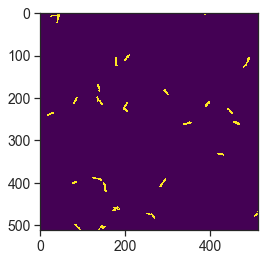

In [10]:
# area thresholds for what we call a bacteria
lower_area = 1 # µm^2
upper_area = 4 # µm^2

# create a blank image with dimensions of im_label
im_mask = np.zeros_like(im_label)

# loop through the objects
for obj in objs:
    
    # compute object area
    area = obj.area * pixel_size**2
    
    # if area is within the thresholds, add this object to the mask
    if (area > lower_area) and (area < upper_area):
        im_mask = im_mask + (im_label == obj.label)
        
plt.imshow(im_mask)

Great! We see that we've cleared out a substantial portion of non-bacteria looking objects. Let's see how many objects remain in this masked image.

In [11]:
# label the remaining objects
im_mask_label = skimage.measure.label(im_mask)

# print the number of object after size filtering
print(im_mask_label.max(), ' objects remain after filtering')

25  objects remain after filtering


## 1.5 Write a masking function

So far we've set up a pipeline for how to get a mask, an image the specifies where bacteria are located, for an single image. Now we just need to put all these operations together into a single function that we can call for **all** images. We've made such a function and have included it in the `pboc_utilites` file. Let's import this file and see that the `create_mask()` function works the same as the code we've written here. 

In [12]:
import pboc_utilities as pboc

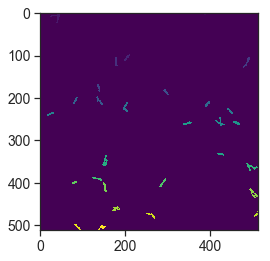

In [13]:
test_mask = pboc.create_mask(im)

plt.imshow(test_mask)

# Step 2: Use our segmentation mask to get fluorescence intensities from a YFP image

Now that we have our mask, we are finally ready to assess the level of fluorescence in the corresponding bacteria. Below we show what the corresponding YFP image looks like.

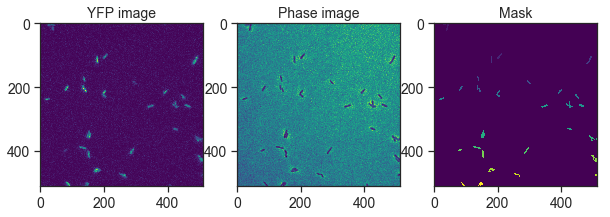

In [14]:
# read the matching YFP image
im_yfp = skimage.io.imread('data/lacI_titration/O2_R22_yfp_pos_19.tif')

# show them next to each other
fig, ax = plt.subplots(1,3, figsize=[10,3])
ax[0].imshow(im_yfp)
ax[0].set_title('YFP image')

ax[1].imshow(im)
ax[1].set_title('Phase image')

ax[2].imshow(test_mask)
ax[2].set_title('Mask');

To get the corresponding fluorescence values for the bacteria, we will again use `skimage.measure.regionprops()`, this time giving it two images: the first is `label_image` which serves as the mask with which to query the `intensity_image` which contains the quantitative information we wish to assess (i.e. the YFP expression). For each object in the `label_image,` it will find the corresponding pixels in the`intensities_image`, and compute the properties (like area, mean expression, etc.) of this region. 

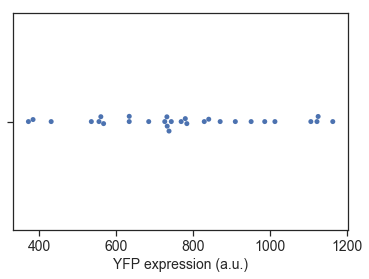

In [15]:
# list to store the object intensity values
intensities = []

# obtain the features of objects in the YFP channel
objs = skimage.measure.regionprops(label_image=test_mask, intensity_image=im_yfp)

# add the YFP intensity values
for obj in objs:
    intensities.append(obj.mean_intensity)
    
# show intensities
sns.swarmplot(intensities)
plt.xlabel("YFP expression (a.u.)");

## Write a function to find the YFP intensities

Now that we have a way to find the YFP intensities for a single image, let's turn it into a function that returns the intensities for any given YFP and mask image. 

In [16]:
def find_intensities(im_mask_label, im_yfp):
    """
    Returns a list of YFP intensities using im_mask_label
    as a segmentation mask for the YFP image, im_yfp.
    """

    # list to store the object intensity values
    intensities = []

    # obtain the features of objects in the YFP channel
    objs = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

    # add the YFP intensity values
    for obj in objs:
        intensities.append(obj.mean_intensity)
    
    return intensities

# Step 3: Get YFP intensities for all images of a given strain

We are making progress towards our ultimate goal of comparing the YFP expression in strains with different binding sites and different repressor copy numbers. We have a pipeline in place that will find the segmentation mask of a phase image and then get the mean intensities of the bacteria in the corresponding YFP image. Let's now work on getting the YFP intensities for **all** the images of a given strain.

In [17]:
# strain information
operator = 'O2'
repressor = 'R22'

# array to store intensity values from all the strains
intensities_all = []

# filename structure
file_structure_phase = './data/lacI_titration/' + operator + '_' + repressor + '_' + 'phase*'
file_structure_yfp = './data/lacI_titration/' + operator + '_' + repressor + '_' + 'yfp*'

# name of all images for a given strain
phase_names = np.sort(glob.glob(file_structure_phase))
yfp_names = np.sort(glob.glob(file_structure_yfp))

# Number of positions
n_images = len(phase_names)

# loop through the images
for i in range(n_images):
    
    # read in the images
    im_phase = skimage.io.imread(phase_names[i])
    im_yfp = skimage.io.imread(yfp_names[i])
    
    # get the mask from the phase image
    im_mask_label = pboc.create_mask(im_phase)
    
    # get the intensities from the YFP image
    intensities = find_intensities(im_mask_label, im_yfp)
    
    # add the intensities of this image to the master list
    # note that "+" for lists implies concatenation
    intensities_all = intensities_all + intensities 

Let's plot these intensities. 

Text(0,0.5,'frequency')

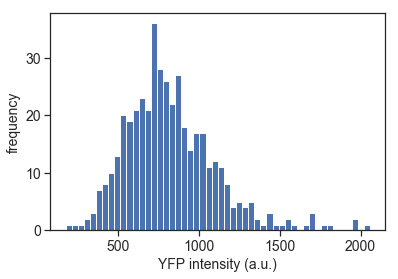

In [18]:
plt.hist(intensities_all, bins=50);
plt.xlabel("YFP intensity (a.u.)")
plt.ylabel("frequency")

## Write a function to get all bacterial intensities for a given strain

Once again, let's take the code we've developed and turn it into a function.

In [19]:
def find_intensities_all(operator, repressor):
    """
    For a given operator / repressor pair, return the YFP
    intensities across all imaging positions
    """
    
    # array to store intensity values from all the strains
    intensities_all = []

    # filename structure
    file_structure_phase = './data/lacI_titration/' + operator + '_' + repressor + '_' + 'phase*'
    file_structure_yfp = './data/lacI_titration/' + operator + '_' + repressor + '_' + 'yfp*'

    # name of all images for a given strain
    phase_names = np.sort(glob.glob(file_structure_phase))
    yfp_names = np.sort(glob.glob(file_structure_yfp))

    # Number of positions
    n_images = len(phase_names)

    # loop through the images
    for i in range(n_images):

        # read in the images
        im_phase = skimage.io.imread(phase_names[i])
        im_yfp = skimage.io.imread(yfp_names[i])

        # get the mask from the phase image
        im_mask_label = pboc.create_mask(im_phase)

        # get the intensities from the YFP image
        intensities = find_intensities(im_mask_label, im_yfp)

        # add the intensities of this image to the master list
        # note that "+" for lists implies concatenation
        intensities_all = intensities_all + intensities 
        
    return intensities_all

# Step -2: Plot the theory curves

To show we haven't "cooked the books," let's plot the theory curves before we look at the results of our data analysis. As we've derived in lecture, the fold-change equation is given by

$$ \text{fold-change}(R) = \frac{1}{1 + \frac{R}{N_{NS}}e^{-\beta \ \epsilon_R}}, \tag{1}$$

where $R$ is the number of repressors, $N_{NS}$ is the number of non-specific binding sites (which we will take to be the length of the genome), and $\epsilon_R$ is the binding energy of the repressor to the DNA. Below, let's plot our theroy curve for our three operator binding site O1, O2, and O3 which have the corresponding binding enegeries: $-15.3$, $-13.9$, and $-9.3 \ k_BT$.

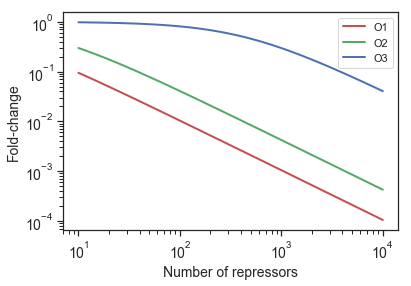

In [20]:
# number of non-specific sites
NNS = 4.6E6

# repressor binding energies in kT units
dE = [-15.3, -13.9, -9.3]

# range of repressor copy numbers, 10 to 10,000
R_range = np.logspace(1, 4, 100)

# assign a color to each operator
colors = ['r', 'g', 'b']

# find and plot the theoretical predictions
for i in range(len(dE)):
    fold_change = 1/(1 + R_range/ NNS * np.exp(-dE[i]))
    plt.loglog(R_range, fold_change, color = colors[i])

plt.xlabel('Number of repressors')
plt.ylabel('Fold-change')
plt.legend(["O1","O2","O3"])